# Regression

Regresyon Modeli, sürekli bir çıktıyı tahmin etmek için bağımsız değişkenler ile bağımlı değişken arasındaki ilişkileri modelleyen bir algoritmadır. Bu model, özellikle veri noktalarının eğilimlerini anlamak ve gelecekteki değerleri öngörmek için kullanılır.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Veri setini okuyarak DataFrame oluşturalım
import pandas as pd

df = pd.read_excel("cars.xls")

**Not:** Excel dosyasını okumak için xlrd paketine ihtiyaç duyulabilir. Bunun için aşağıdaki kodu çalıştırarak kurabilirsiniz.
```python
pip install xlrd
```

### Keşfedici Veri Analizi (EDA)

(EDA işlemleri ile ilgili detaylı bilgi için <a href="../../Data-Preprocessing/03-Exploratory-Data-Analysis/Exploratory-Data-Analysis.ipynb" target="_blank">buraya</a> bakabilirsiniz.)

In [2]:
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Model     804 non-null    object 
 4   Trim      804 non-null    object 
 5   Type      804 non-null    object 
 6   Cylinder  804 non-null    int64  
 7   Liter     804 non-null    float64
 8   Doors     804 non-null    int64  
 9   Cruise    804 non-null    int64  
 10  Sound     804 non-null    int64  
 11  Leather   804 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 75.5+ KB


**Veri setindeki alanlar:**
* Price: (Hedef alan) Arabanın fiyatı.
* Mileage: Arabanın şu anki kilometresi (mil cinsinden)
* Make: Arabanın markası
* Model: Arabanın modeli
* Trim: Arabanın alt modeli
* Type: Arabanın tipi
* Cylinder: Arabadaki silindir sayısı
* Liter: Arabanın motor hacmi
* Doors: Arabanın kapı sayısı
* Cruise: Hız sabitleme özelliği var mı? (1: Evet, 0: Hayır)
* Sound: Ses sitemi var mı? (1: Evet, 0: Hayır)
* Leather: Koltukları deri mi? (1: Evet, 0: Hayır)

### Veri Görselleştirme

(Veri görselleştirme işlemleri ile ilgili detaylı bilgi için <a href="../../Data-Preprocessing/02-Data-Visualization/Data-Visualization.ipynb" target="_blank">buraya</a> bakabilirsiniz.)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

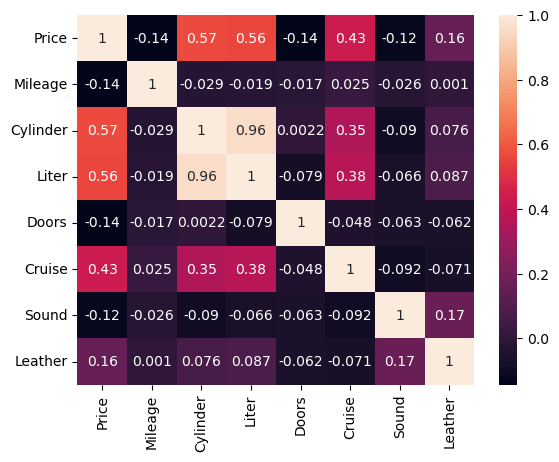

In [5]:
# Alanlar arasındaki korelasyona bakalım

sns.heatmap(df.corr(numeric_only=True), annot=True)

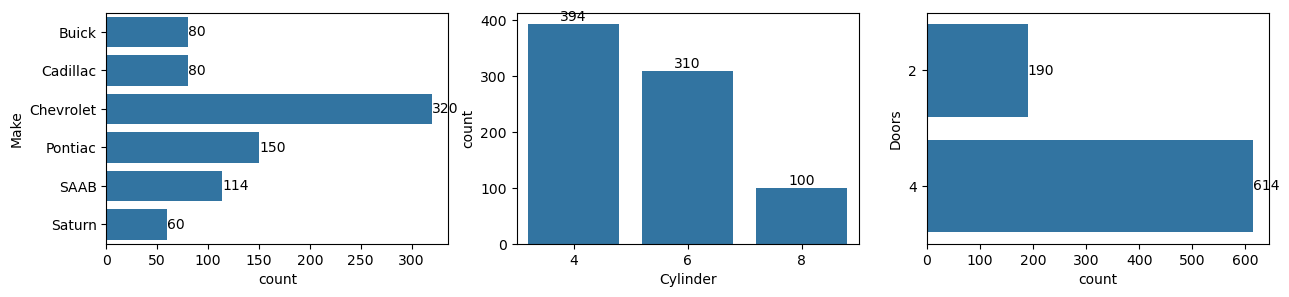

In [6]:
fig = plt.figure(figsize=(15,3))

# Her bir markadan kaç adet araç var?
ax = fig.add_subplot(131)
ax = sns.countplot(y=df["Make"])
ax.bar_label(ax.containers[0])

# Her bir kapı sayısından kaç adet var?
bx = fig.add_subplot(132)  # 1 satır, 3 sütunlu tablonun 2. hücresi
bx = sns.countplot(x=df["Cylinder"])
bx.bar_label(bx.containers[0])


# Her bir kapı sayısından kaç adet var?
cx = fig.add_subplot(133)  # 1 satır, 3 sütunlu tablonun 3. hücresi
cx = sns.countplot(y=df["Doors"])
cx.bar_label(cx.containers[0]);

### Özellik Mühendisliği

(Özellik mühendisliği işlemleri ile ilgili detaylı bilgi için <a href="../../Data-Preprocessing/05-Feature-Engineering/Feature-Engineering.ipynb" target="_blank">buraya</a> bakabilirsiniz.)

In [7]:
# Modelde kullanacağımız alanları seçmek için hedef alan ile ilişkili (korelasyona sahip) alanları belirleyelim.

# Price alanının diğer alanlarla korelasyonunu hesapla ve büyükten küçüğe doğru sırala
abs(df.corr(numeric_only=True)["Price"]).sort_values(ascending=False)

# abs() mutlak değer fonksiyonu ile negatif korelasyonları da pozitife çevirip öyle sıralıyoruz

Price       1.000000
Cylinder    0.569086
Liter       0.558146
Cruise      0.430851
Leather     0.157197
Mileage     0.143051
Doors       0.138750
Sound       0.124348
Name: Price, dtype: float64

**Özellik seçimi** (Feature selection) işleminde aşağıdaki alanları modele dahil ediyoruz:
* Cylinder, Liter ve Cruise alanları korelasyonları %20-90 arasında olduğu için
* Milage alanı düşük korelasyona sahip olsada gerçek hayatta araba fiyatına etkili olduğu bilindiği için seçiliyor.

In [8]:
# x modelin girdi alanlarını, y ise çıktı (hedef) alanını temsil ediyor.

x=df[["Mileage", "Cylinder", "Liter", "Cruise"]]
y=df[["Price"]]

## Model Geliştirme

### Train-Test Split

Veri setini eğitim (train) ve test olmak üzere ikiye ayırıyoruz. Eğitim verileri ile geliştirilen model daha sonra test verileri ile kontrol edilerek başarısı denenir. <br>

<img src="train-test-split.jpg"><br>
Resmin alındığı [bu sayfadan](https://builtin.com/data-science/train-test-split) detaylı bilgi alınabilir.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Orjinal veri seti önce aşağıdaki bölümlere ayrıldı:
- x: Modelin girdi alanları
- y: Modelin hedef (tahmin edilecek) alanı

Bölünme işleminden sonra aşağıdaki bölümler oluştu:
- x_train: Eğitim için ayrılan girdi alanları
- x_test: Test için ayrılan girdi alanları
- y_train: Eğitim için ayrılan hedef alan
- y_test: Test için ayrılan hedef alan

test_size: Bu parametre bölünme aşamasında test için ayrılan oranı belirler
random_state: Bu parametr, train-test split işlemi sırasında verinin rastgele bölünmesinin tekrarlanabilir olmasını sağlar. Aynı random_state değeri kullanıldığında, her çalışmada aynı veri bölünmesi elde edilir, bu da model sonuçlarının tutarlı ve karşılaştırılabilir olmasına yardımcı olur.


In [11]:
x.shape, y.shape

((804, 4), (804, 1))

In [12]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((643, 4), (161, 4), (643, 1), (161, 1))

Orjinal veri seti 804 satırdan (4+1) ve 5 sütundan oluşuyorken, bölünmeden sonra eğitim verisi 643 satır (yaklaşık %80), test verisi de 161 satır (yaklaşık %20) veri içermektedir.

### Linear Regression

In [13]:
# Modelin başarısını ölçmek için kullanılan kütüphaneler
from sklearn.metrics import r2_score, mean_squared_error

# LinearRegression kütüphanesi
from sklearn.linear_model import LinearRegression

In [14]:
# Yeni bir LinearRegression nesnesi tanımlayalım
lr=LinearRegression()

In [15]:
# Modeli eğitelim
model=lr.fit(x_train, y_train)

In [16]:
# Test verilerini tahmin edelim
tahmin=model.predict(x_test)

**`mean_squared_error` (MSE)** fonksiyonu, bir modelin tahminlerinin doğruluğunu ölçmek için kullanılan bir hata metriğidir. Tahmin edilen değerler ile gerçek değerler arasındaki farkların karesi alınır ve bu karelerin ortalaması hesaplanır. Daha küçük bir \( MSE \), modelin daha iyi performans gösterdiğini ve tahminlerin gerçeğe daha yakın olduğunu gösterir.

Formül şu şekildedir:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Burada:

$$
y_i : \text{Gerçek değerler}
$$

$$
\hat{y}_i : \text{Tahmin edilen değerler}
$$

$$
n : \text{Veri noktalarının sayısı}
$$

MSE, hataları büyüttüğü için büyük hatalara daha fazla ağırlık verir.

In [17]:
# MSE değerini hesaplayalım
mean_squared_error(y_test, tahmin)**0.5

7413.255792158801

**`r2_score` (R-kare)**, bir regresyon modelinin açıklayıcılık gücünü ölçen bir metriği temsil eder. Bu değer, modelin bağımlı değişkendeki varyansın ne kadarını açıkladığını gösterir. R-kare değeri, 0 ile 1 arasında bir değer alır; 1 değeri, modelin veriyi mükemmel bir şekilde açıkladığını, 0 değeri ise modelin hiçbir açıklayıcılığı olmadığını gösterir.

Formül şu şekildedir:

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

Burada:
$$
SS_{res} : \text{Modelin tahminleri ile gerçek değerler arasındaki kare farkların toplamı, yani hata kare toplamı.}
$$

$$
SS_{tot} : \text{Gerçek değerlerin ortalaması etrafındaki toplam varyans, yani toplam kare toplamı.}
$$

R-kare, modelin tahmin gücünü değerlendirmek için yaygın olarak kullanılır ve daha yüksek R-kare değerleri, daha iyi bir model performansını gösterir.


In [18]:
# R-kare değerini hesaplayalım
r2_score(y_test, tahmin)

0.30711149069980015

MSE: 7413.25$, bu değer tahmin edilen fiyatın hata büyüklüğü (oldukça yüksek)<br>
R-kare: %30.7 modelin tahmin başarısı (oldukça düşük). <br>
Modelde sadece sayısal alanları kullandık ve düşük başarı elde ettik. Modele arabanın marka ve modellerini de eklememiz gerekiyor. Bunun için **özellik mühendisliğine** devam ediyoruz.

In [19]:
# Girdi alanlarına (x) metinsel alanları da ekleyelim 
x=df[["Mileage", "Cylinder", "Liter", "Cruise", "Make", "Trim"]]
y=df[["Price"]]

x.head()

,Mileage,Cylinder,Liter,Cruise,Make,Trim
0,8221,6,3.1,1,Buick,Sedan 4D
1,9135,6,3.1,1,Buick,Sedan 4D
2,13196,6,3.1,1,Buick,Sedan 4D
3,16342,6,3.1,1,Buick,Sedan 4D
4,19832,6,3.1,1,Buick,Sedan 4D


In [20]:
# Veri setindeki tüm metinsel alanlar için one-hot encoding uygulayalım.

x=pd.get_dummies(x, drop_first=True)
x.head()

,Mileage,Cylinder,Liter,Cruise,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn,Trim_Aero Conv 2D,...,Trim_Quad Coupe 2D,Trim_SE Sedan 4D,Trim_SLE Sedan 4D,Trim_SS Coupe 2D,Trim_SS Sedan 4D,Trim_SVM Hatchback 4D,Trim_SVM Sedan 4D,Trim_Sedan 4D,Trim_Special Ed Ultra 4D,Trim_Sportwagon 4D
0,8221,6,3.1,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,9135,6,3.1,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,13196,6,3.1,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,16342,6,3.1,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,19832,6,3.1,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [39]:
# Bölümleme işlemini yeniden yapıyoruz

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# random_state=42 ile önceki bölümlemede kullanılan verilerin aynısını kullanmış olduk.

((643, 55), (161, 55), (643, 1), (161, 1))

In [22]:
# Modeli yeniden eğitip, test verilerini tahmin edelim
model=lr.fit(x_train, y_train)
tahmin=model.predict(x_test)

In [23]:
# MSE değerini yeniden hesaplayalım
mean_squared_error(y_test, tahmin)**0.5

1523.631472871132

In [24]:
# R-kare değerini yeniden hesaplayalım
r2_score(y_test, tahmin)

0.9707311770106378

### Regression Modellerinde Başarı Ölçütleri

Bir modelin başarılı sayılabilmesi için:
- En az %85 (R-kare) tahmin başarısı elde etmesi
- Hata miktarının (RMSE) oldukça küçük olması
- Tahmin ile gerçek değerler arasındaki fark (residuals) değerlerinin normal dağılım göstermesi

Geliştirilen modelde:
- R-kare: %97.07 (oldukça yüksek)
- MSE: 1523.63$ (oldukça düşük)
- Residuals: ? 

Şimdi buna bakalım.

In [25]:
# Fark değerlerini (residuals) hesaplayalım
residuals=y_test-tahmin

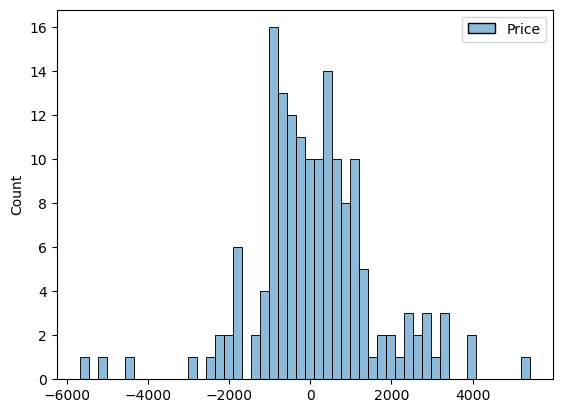

In [26]:
# Değerlerin dağılım grafiği
sns.histplot(residuals, bins=50);

<Axes: xlabel='Price', ylabel='Density'>

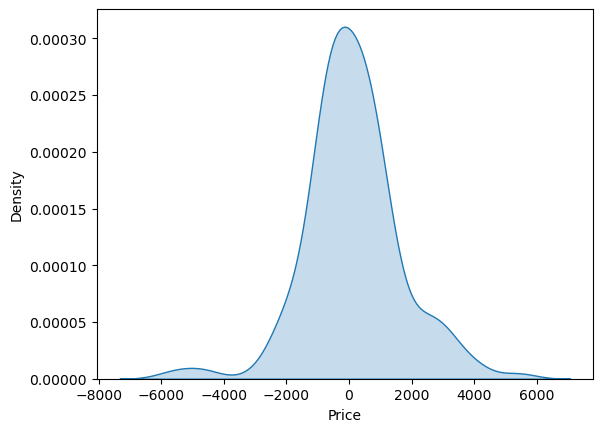

In [27]:
# Dağılım eğrisine bakalım
sns.kdeplot(x=residuals["Price"], fill=True)

Yukarıdaki grafiğe göre fark değerlerinin de normal dağıldığı söylenebilir. Özellikle 0'ya yakın değerlerin nispeten yüksek olması sevindirici.

### Ridge

In [28]:
import numpy as np
from sklearn.linear_model import Ridge

In [29]:
r = Ridge()

rModel=r.fit(x_train, y_train)
rTahmin=rModel.predict(x_test)

mse = mean_squared_error(y_test, rTahmin) ** 0.5
r2 = r2_score(y_test,rTahmin)

print("MSE: $"+str(np.round(mse,2)), " r-kare: %"+str(np.round(r2*100, 2)))

MSE: $1575.68  r-kare: %96.87


### Lasso

In [30]:
from sklearn.linear_model import Lasso

In [31]:
l = Lasso()

lModel=l.fit(x_train, y_train)
lTahmin=lModel.predict(x_test)

mse = mean_squared_error(y_test, lTahmin) ** 0.5
r2 = r2_score(y_test,lTahmin)

print("MSE: $"+str(np.round(mse,2)), " r-kare: %"+str(np.round(r2*100, 2)))

MSE: $1527.04  r-kare: %97.06


### ElasticNet

In [32]:
from sklearn.linear_model import ElasticNet

In [33]:
e = ElasticNet()

eModel=e.fit(x_train, y_train)
eTahmin=eModel.predict(x_test)

mse = mean_squared_error(y_test, eTahmin) ** 0.5
r2 = r2_score(y_test,eTahmin)

print("MSE: $"+str(np.round(mse,2)), " r-kare: %"+str(np.round(r2*100, 2)))

MSE: $5916.12  r-kare: %55.87


### DecisionTreeRegressor

In [37]:
from sklearn.tree import DecisionTreeRegressor

In [38]:
dt = DecisionTreeRegressor()

dtModel=dt.fit(x_train, y_train)
dtTahmin=dtModel.predict(x_test)

mse = mean_squared_error(y_test, dtTahmin) ** 0.5
r2 = r2_score(y_test,dtTahmin)

print("MSE: $"+str(np.round(mse,2)), " r-kare: %"+str(np.round(r2*100, 2)))

MSE: $1780.12  r-kare: %96.0


### ExtraTreesRegressor

In [34]:
from sklearn.ensemble import ExtraTreesRegressor

In [35]:
et = ExtraTreesRegressor()

etModel=et.fit(x_train, y_train)
etTahmin=etModel.predict(x_test)

mse = mean_squared_error(y_test, etTahmin) ** 0.5
r2 = r2_score(y_test,etTahmin)

print("MSE: $"+str(np.round(mse,2)), " r-kare: %"+str(np.round(r2*100, 2)))

MSE: $878.79  r-kare: %99.03


### Modellerin Karşılaştırılması

| Model Adı              | MSE     | R2   |
|------------------------|---------|------|
| LinearRegression        | 1523.63 | 0.97 |
| Ridge                  | 1575.68 | 0.97 |
| Lasso                  | 1527.04 | 0.97 |
| ElasticNet             | 5916.12 | 0.56 |
| DecisionTreeRegressor   | 1780.12 | 0.96 |
| ExtraTreesRegressor     | 878.79  | 0.99 |

### Kısa Yorum:
- **ExtraTreesRegressor** modelinin, hem düşük bir MSE (878.79) hem de yüksek bir \(R^2\) skoru (0.99) ile en iyi performansı gösterdiği açıkça görülüyor.
- **LinearRegression**, **Ridge** ve **Lasso** modelleri benzer performans gösteriyor ve \(R^2\) skorları 0.97 ile oldukça iyi. MSE'leri de düşük, ancak ExtraTreesRegressor kadar iyi değil.
- **ElasticNet** modeli, diğer modellere kıyasla çok daha yüksek bir MSE (5916.12) ve düşük bir \(R^2\) skoru (0.56) ile açık bir şekilde daha düşük bir performans sergiliyor.
- **DecisionTreeRegressor** modeli de makul bir performans sunuyor, ancak ExtraTreesRegressor modelinden daha kötü durumda.


# Son Söz

Bu projede Regresyon Makine Öğrenme Modeli geliştirme örnekleri sunduk. Bunu yaparken aşağıdaki işlemleri uyguladık:

* Model geliştirme öncesinde veri okuma, keşfedici veri analizi, veri görselleştirme ve özellik mühendisliği işlemlerine değindik. * Veri setini eğitim ve test olmak üzere kısımlara ayırdık.
* LinearRegression, Ridge, Lasso, ElasticNet, DecisionTreeRegressor ve ExtraTreesRegressor modelleri ile demeler yaptık.

Elbetteki tüm regresyon modelleri bu kadar değil. Modellerin geliştirilmesinde **scikit-learn (sklearn)** kütüphaneleri kullandık. Daha fazla model ve bu kütüphaneler hakkında detaylı bilgiye aşağıdaki bağlantıdan ulaşabilirsiniz. <br><br>

<a href="https://scikit-learn.org/stable/supervised_learning.html" target="_blank"><img src="https://scikit-learn.org/stable/_static/scikit-learn-logo-small.png"></a>